In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [19]:
data = pd.read_csv("../../data/stats_by_game_played_with_home_away.csv", low_memory=False)
df = data.copy().drop(columns=["year", "gw", "player", "birth_date", "influence", "creativity", "threat"])
print(df.columns)

Index(['n_games_in_gw', 'points_scored', 'avg_home',
       'playing_against_mean_difficulty', 'playing_against_mean_defence',
       'playing_against_mean_attack', 'playing_for_difficulty',
       'playing_for_defence', 'playing_for_attack', 'form', 'position',
       'selected', 'playing_chance', 'corners_and_free_kicks_order',
       'penalties_order', 'avg_minutes_when_playing',
       'avg_points_when_playing', 'avg_yellows_p_game_when_playing',
       'avg_reds_p_game_when_playing', 'avg_bps_p_game_when_playing',
       'avg_goals_p_game_when_playing', 'avg_assists_p_game_when_playing',
       'avg_clean_sheets_when_playing', 'avg_goals_conceded_when_playing',
       'avg_starts_when_playing', 'avg_saves_when_playing'],
      dtype='object')


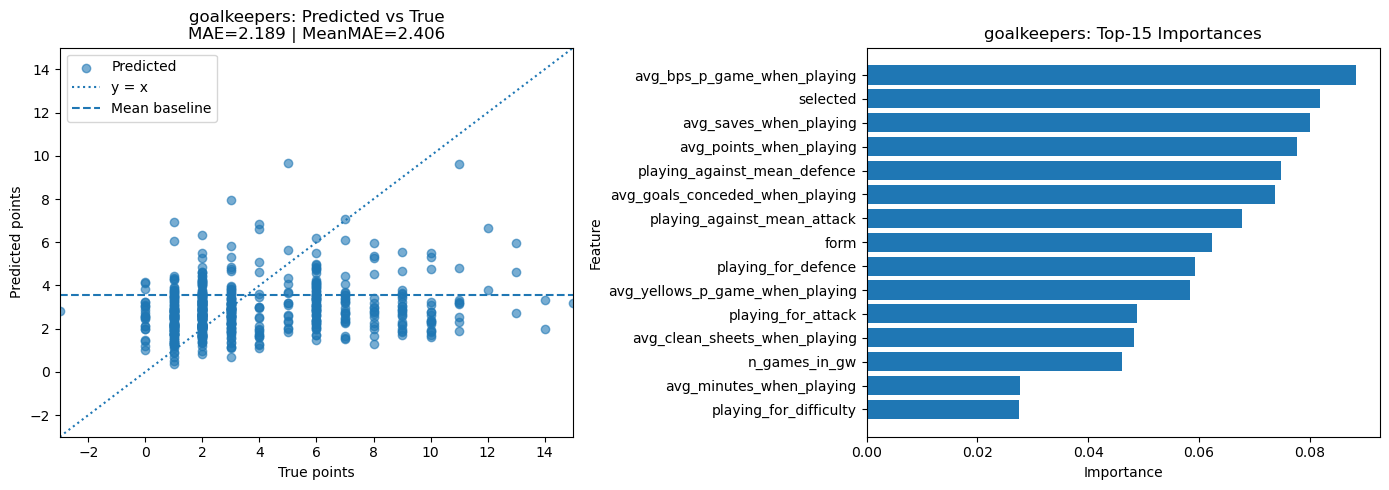

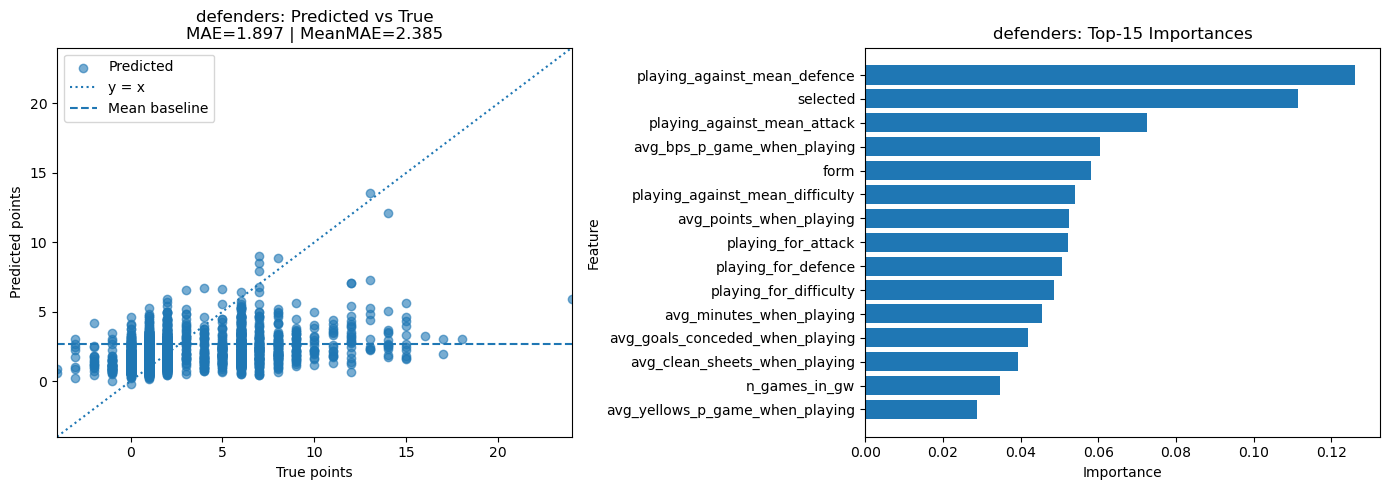

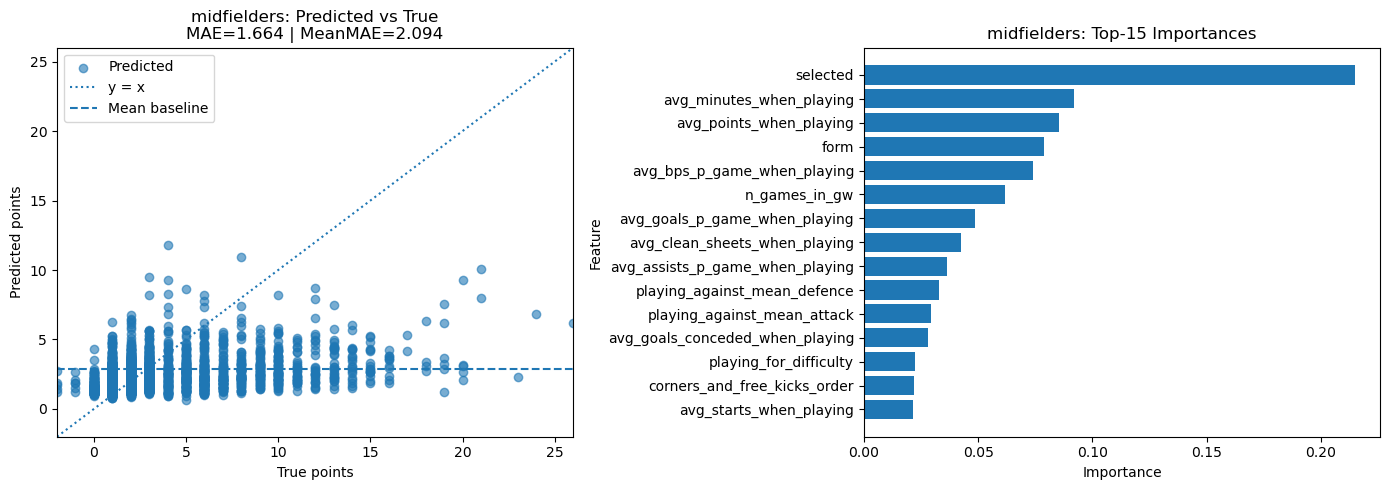

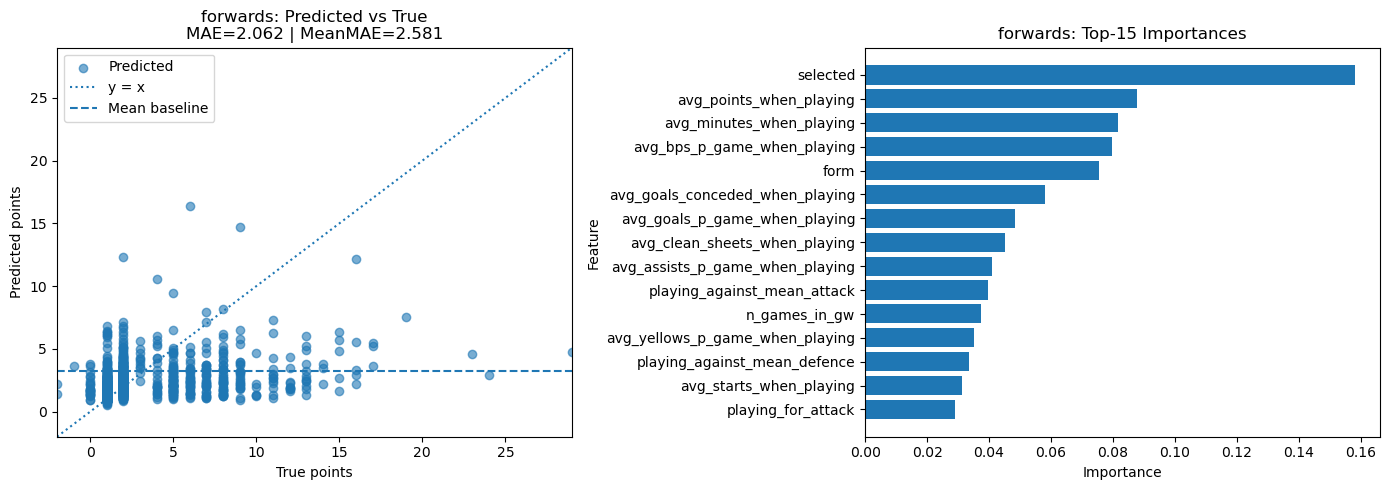

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

pos_map = {1:"goalkeepers", 2:"defenders", 3:"midfielders", 4:"forwards"}
TOPK = 15
models = []

def s_log1p(a):
    a = np.asarray(a, dtype=float)
    return np.sign(a) * np.log1p(np.abs(a))

def s_expm1(a):
    a = np.asarray(a, dtype=float)
    return np.sign(a) * np.expm1(np.abs(a))

for i in range(1, 5):
    pos_df = df[df["position"] == i].copy()
    if pos_df.empty:
        print(f"[{pos_map[i]}] no rows, skipping."); continue

    # keep only rows with non-null target
    pos_df = pos_df.drop(columns=["position"])
    pos_df = pos_df.dropna(subset=["points_scored"])

    y = pos_df["points_scored"].astype(float)
    X = pos_df.drop(columns=["points_scored"])

    # numeric-only features
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    if not num_cols:
        print(f"[{pos_map[i]}] no numeric features, skipping."); continue
    X = X[num_cols]

    # impute X
    imputer = SimpleImputer(strategy="median")
    X_imp = imputer.fit_transform(X)

    # split
    X_train, X_test, y_train, y_test = train_test_split(
        X_imp, y, test_size=0.2, random_state=42
    )

    # ---- robust model with signed-log target ----
    y_train_t = s_log1p(y_train)

    gbr = GradientBoostingRegressor(
        loss="huber",
        learning_rate=0.05,
        n_estimators=1200,
        max_depth=3,
        subsample=0.8,
        max_features="sqrt",
        random_state=42
    )
    gbr.fit(X_train, y_train_t)

    # predict and invert transform
    y_pred_t = gbr.predict(X_test)
    y_pred = s_expm1(y_pred_t)

    # mean baseline in original space
    mean_baseline = np.full_like(y_test, y_train.mean(), dtype=float)

    # --- metrics ---
    mae_model = mean_absolute_error(y_test, y_pred)
    mae_mean  = mean_absolute_error(y_test, mean_baseline)

    # --- feature importances ---
    importances = getattr(gbr, "feature_importances_", None)
    feat_imp = (pd.DataFrame({"feature": num_cols, "importance": importances})
                .sort_values("importance", ascending=False)
                .reset_index(drop=True))
    topk_imp = feat_imp.head(min(TOPK, len(feat_imp)))

    models.append({
        "position_id": i,
        "position": pos_map[i],
        "model": gbr,
        "imputer": imputer,
        "num_cols": num_cols,
        "metrics": {"MAE": mae_model, "MAE_mean": mae_mean},
        "feature_importances": feat_imp
    })

    # -------- PLOTS (one figure per position) --------
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Left: Predicted vs True scatter with y=x and mean baseline
    ax = axes[0]
    ax.scatter(y_test, y_pred, alpha=0.6, label="Predicted")
    lims = [
        float(np.floor(min(y_test.min(), y_pred.min()))),
        float(np.ceil(max(y_test.max(), y_pred.max())))
    ]
    ax.plot(lims, lims, linestyle=":", label="y = x")
    ax.axhline(y_train.mean(), linestyle="--", label="Mean baseline")
    ax.set_xlim(lims); ax.set_ylim(lims)
    ax.set_xlabel("True points"); ax.set_ylabel("Predicted points")
    ax.set_title(f"{pos_map[i]}: Predicted vs True\nMAE={mae_model:.3f} | MeanMAE={mae_mean:.3f}")
    ax.legend(loc="best")

    # Right: Top-K importances
    ax = axes[1]
    ax.barh(topk_imp["feature"][::-1], topk_imp["importance"][::-1])
    ax.set_title(f"{pos_map[i]}: Top-{len(topk_imp)} Importances")
    ax.set_xlabel("Importance"); ax.set_ylabel("Feature")

    fig.tight_layout()
    plt.show()


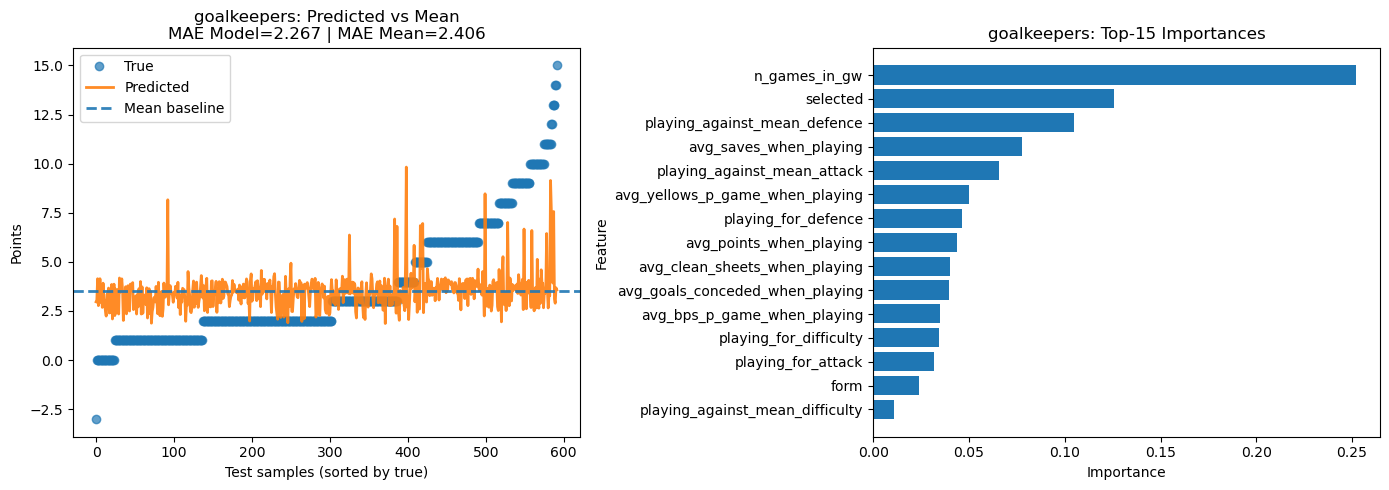

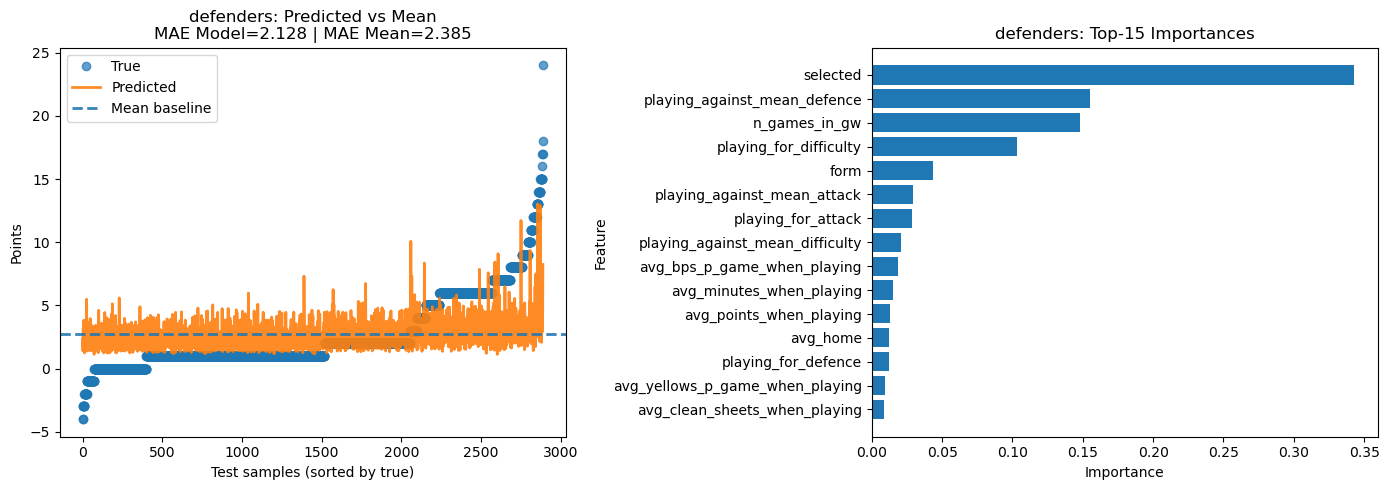

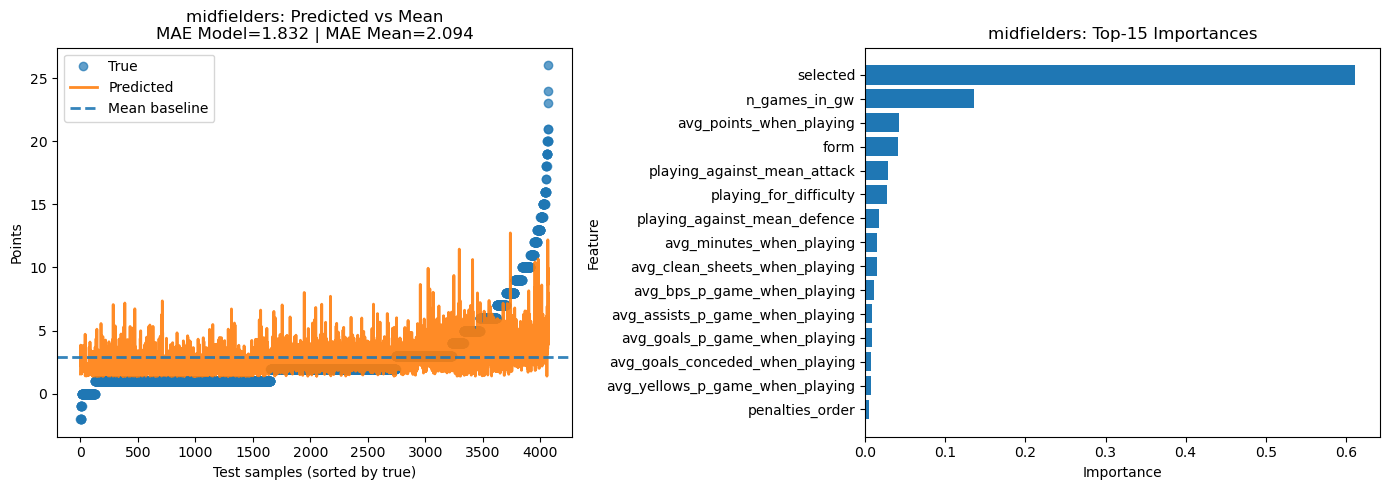

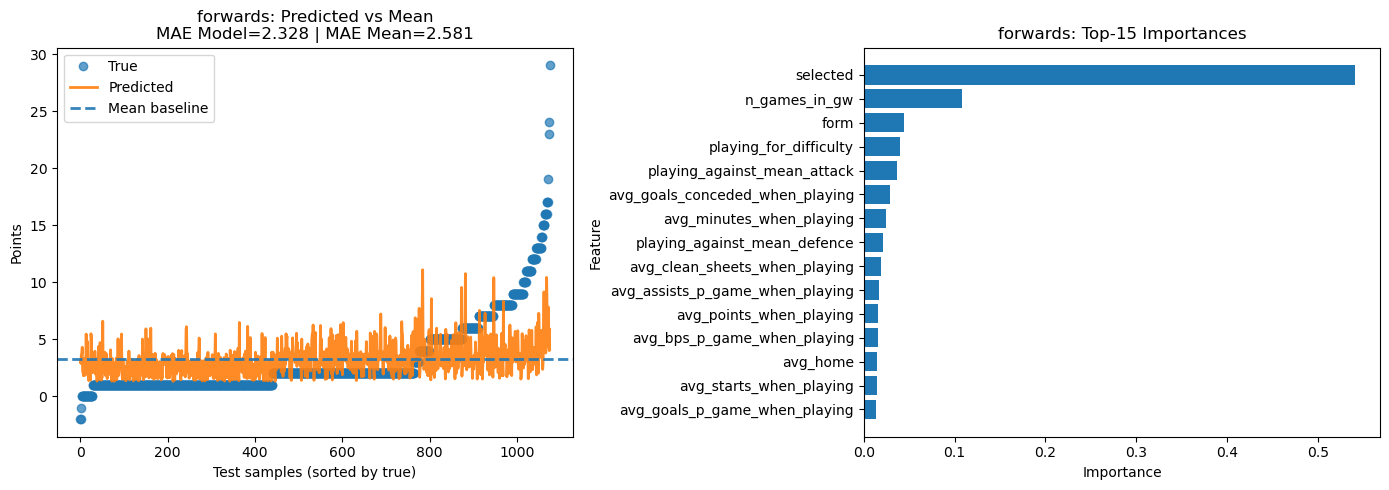

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
# (Optional) from sklearn.metrics import mean_squared_error, r2_score

pos_map = {
    1: "goalkeepers",
    2: "defenders",
    3: "midfielders",
    4: "forwards"
}

TOPK = 15
models = []

for i in range(1, 5):
    # ---- subset & split X/y ----
    pos_df = df[df["position"] == i].copy()
    if pos_df.empty:
        print(f"[{pos_map[i]}] no rows, skipping.")
        continue

    pos_df = pos_df.drop(columns=["position"])
    if "points_scored" not in pos_df.columns:
        raise ValueError("Column 'points_scored' missing from dataframe.")

    y = pos_df["points_scored"].astype(float)
    X = pos_df.drop(columns=["points_scored"])

    # numeric-only features for RF
    num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
    if len(num_cols) == 0:
        print(f"[{pos_map[i]}] no numeric features, skipping.")
        continue
    X = X[num_cols]

    # ---- impute ----
    imputer = SimpleImputer(strategy="median")
    X_imp = imputer.fit_transform(X)

    # ---- train/test split (no stratify for regression) ----
    X_train, X_test, y_train, y_test = train_test_split(
        X_imp, y, test_size=0.2, random_state=42
    )

    # ---- model ----
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=5,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # ---- predictions & baseline ----
    y_pred = rf.predict(X_test)
    y_mean = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)

    # ---- metrics ----
    mae_model = mean_absolute_error(y_test, y_pred)
    mae_baseline = mean_absolute_error(y_test, y_mean)
    # rmse_model = mean_squared_error(y_test, y_pred, squared=False)
    # r2 = r2_score(y_test, y_pred)

    # ---- feature importances ----
    importances = rf.feature_importances_
    feat_imp = (
        pd.DataFrame({"feature": num_cols, "importance": importances})
        .sort_values("importance", ascending=False)
        .reset_index(drop=True)
    )
    topk_imp = feat_imp.head(min(TOPK, len(feat_imp)))

    # ---- store artifacts ----
    models.append({
        "position_id": i,
        "position": pos_map[i],
        "model": rf,
        "imputer": imputer,
        "num_cols": num_cols,
        "y_test": np.array(y_test),
        "y_pred": y_pred,
        "y_mean": y_train.mean(),
        "feature_importances": feat_imp,
        "mae_model": mae_model,
        "mae_baseline": mae_baseline,
    })

    # ---- plotting: predicted vs mean (left) + top-K importances (right) ----
    # sort by true value for readability
    order = np.argsort(y_test)
    yt_sorted = np.array(y_test)[order]
    yp_sorted = y_pred[order]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Left: truth vs model vs mean-baseline
    ax = axes[0]
    ax.plot(yt_sorted, marker='o', linestyle='None', alpha=0.7, label='True')
    ax.plot(yp_sorted, linewidth=2, alpha=0.9, label='Predicted')
    ax.axhline(models[-1]["y_mean"], linestyle='--', linewidth=2, alpha=0.9, label='Mean baseline')
    ax.set_title(f"{pos_map[i]}: Predicted vs Mean\nMAE Model={mae_model:.3f} | MAE Mean={mae_baseline:.3f}")
    ax.set_xlabel("Test samples (sorted by true)")
    ax.set_ylabel("Points")
    ax.legend(loc="best")

    # Right: feature importances (Top-K)
    ax = axes[1]
    ax.barh(topk_imp["feature"][::-1], topk_imp["importance"][::-1])
    ax.set_title(f"{pos_map[i]}: Top-{len(topk_imp)} Importances")
    ax.set_xlabel("Importance")
    ax.set_ylabel("Feature")
    fig.tight_layout()
    plt.show()

